# Predicting youtube trending videos with positive examples

In [100]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import random
from datetime import time
%matplotlib inline

random.seed(100)

datadir = './data/'

data_raw = pd.read_csv(datadir + 'USvideos.csv')
tidy = data_raw.copy(deep=True)
data_raw.head(5)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John..."
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...


# Preprocessing

Convert times to date

In [101]:
tidy['publish_time'] = pd.to_datetime(tidy.publish_time)
tidy['publish_date'] = pd.DatetimeIndex(tidy.publish_time).normalize()
tidy['trending_date'] = '20' + tidy['trending_date'] 
tidy['trending_date'] = pd.to_datetime(tidy.trending_date, format='%Y.%d.%m')

Convert the publish time to which day of the week it was published on

In [102]:
weekday_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
tidy['published_weekday'] = tidy.publish_time.dt.dayofweek
tidy['published_weekday'] = tidy['published_weekday'].apply(lambda x: weekday_labels[int(x)])

Get the number of days between published and trending

In [103]:
tidy['days_till_trending'] = tidy['trending_date'] - tidy['publish_date']
tidy['days_till_trending'] = tidy['days_till_trending'].dt.days

In [104]:
tidy.head(5)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,publish_date,published_weekday,days_till_trending
0,2kyS6SvSYSE,2017-11-14,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13 17:13:01,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...,2017-11-13,Monday,1
1,1ZAPwfrtAFY,2017-11-14,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13 07:30:00,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John...",2017-11-13,Monday,1
2,5qpjK5DgCt4,2017-11-14,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12 19:05:24,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...,2017-11-12,Sunday,2
3,puqaWrEC7tY,2017-11-14,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13 11:00:04,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...,2017-11-13,Monday,1
4,d380meD0W0M,2017-11-14,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12 18:01:41,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...,2017-11-12,Sunday,2


### Convert the video category ids to actual readable text

Our tidy data will be in a variable named tidy. We removed ratings, comments, thumbnail_link from out columns. After that, we will start  by binning the publish_time column into Late-night (12am-7am), morning(7am-11am), noon(11am-12pm), afternoon (12pm-7pm), Night(7pm-12am

In [105]:
del tidy['ratings_disabled']
del tidy['comments_disabled']
del tidy['thumbnail_link']
del tidy['video_error_or_removed']

In [106]:
periods = {'12a-6a': [time(0), time(6)], '6a-12p': [time(6), time(12)], 
           '12p-6p': [time(12), time(18)],
          '6p-12a': [time(18), time(23)]}

In [107]:
def bin_values(x, labels=periods):
    for k, v in labels.items():
        if x.hour >= v[0].hour and x.hour < v[1].hour:
            return k
    return 'Unknown_period'
            

In [108]:
tidy['publish_time'] = tidy['publish_time'].apply(bin_values)

We will update the video categories with their representative name

In [109]:
video_categories = pd.read_csv(datadir + 'youtube_video_categories.csv', names=['id', 'title'])

In [110]:
video_categories.head()

,id,title
0,2,Autos & Vehicles
1,1,Film & Animation
2,10,Music
3,15,Pets & Animals
4,17,Sports


In [111]:
cat_values = []
for index, video_id in enumerate(tidy['category_id']):
    cat = video_categories[ video_categories['id'] == video_id]['title'].iloc[0]
    cat_values.append(cat)

tidy['category_names'] = pd.Series(cat_values, index=[i for i in range(0, len(tidy))])

In [112]:
tidy.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,description,publish_date,published_weekday,days_till_trending,category_names
0,2kyS6SvSYSE,2017-11-14,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,12p-6p,SHANtell martin,748374,57527,2966,15954,SHANTELL'S CHANNEL - https://www.youtube.com/s...,2017-11-13,Monday,1,People & Blogs
1,1ZAPwfrtAFY,2017-11-14,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,6a-12p,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,"One year after the presidential election, John...",2017-11-13,Monday,1,Entertainment
2,5qpjK5DgCt4,2017-11-14,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,6p-12a,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...,2017-11-12,Sunday,2,Comedy
3,puqaWrEC7tY,2017-11-14,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,6a-12p,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,Today we find out if Link is a Nickelback amat...,2017-11-13,Monday,1,Entertainment
4,d380meD0W0M,2017-11-14,I Dare You: GOING BALD!?,nigahiga,24,6p-12a,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,I know it's been a while since we did this sho...,2017-11-12,Sunday,2,Entertainment


## Correlation Analysis

Let's analyze the correlation between the variables

In [113]:
tidy[['category_id', 'views', 'likes', 'dislikes', 'comment_count']].corr()

,category_id,views,likes,dislikes,comment_count
category_id,1.000000,-0.077409,-0.105993,0.005148,-0.035137
views,-0.077409,1.000000,0.887709,0.598282,0.761674
likes,-0.105993,0.887709,1.000000,0.482053,0.853390
dislikes,0.005148,0.598282,0.482053,1.000000,0.731331
comment_count,-0.035137,0.761674,0.853390,0.731331,1.000000


We can see that there is high correlation between views, likes, dislikes, and comment_count. Same for the comment_count-views vs views-dislikes Let's apply a t-test and look at the p-values to check if these correlation values are meaningful.

In [114]:
print(scipy.stats.ttest_ind(tidy.views, tidy.comment_count))
print(scipy.stats.ttest_ind(tidy.likes, tidy.comment_count))
print(scipy.stats.ttest_ind(tidy.dislikes, tidy.comment_count))
print(scipy.stats.ttest_ind(tidy.likes, tidy.views))
print(scipy.stats.ttest_ind(tidy.dislikes, tidy.views))

Ttest_indResult(statistic=18.483231182812595, pvalue=3.3713622144242259e-75)
Ttest_indResult(statistic=17.112242651819212, pvalue=7.4999688323612007e-65)
Ttest_indResult(statistic=-4.9624318547073472, pvalue=7.0604365693465466e-07)
Ttest_indResult(statistic=-17.879261606917627, pvalue=1.5083841528194409e-70)
Ttest_indResult(statistic=-18.528354928164944, pvalue=1.4946049335134739e-75)


We can see the p-values are well below 0.05 which indicates they are significant. Below is a plot of the distrubutions between the correlated variables.

## Outlier Detection

By looking at the pairplots above we can see that there are some outliers Let's use a basic linear model to see if we can detected outliers

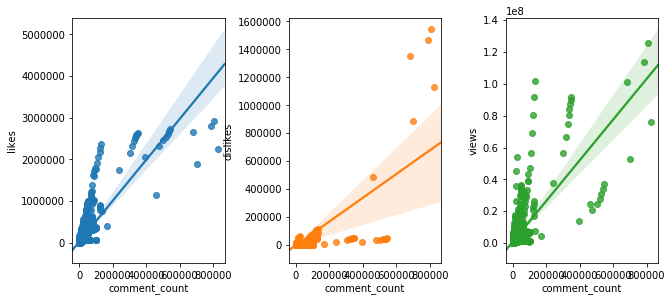

In [115]:
fig, ax = plt.subplots(1, 3)
fig.tight_layout()
plt.subplots_adjust(left=-0.4)
lplot = sns.regplot(data=tidy, x='comment_count', y='likes', ax=ax[0])
#lplot.set(xticks=[])
lplot2 = sns.regplot(data=tidy, x='comment_count', y='dislikes', ax=ax[1])
#lplot2.set(xticks=[])
lplot3 = sns.regplot(data=tidy, x='comment_count', y='views', ax=ax[2])

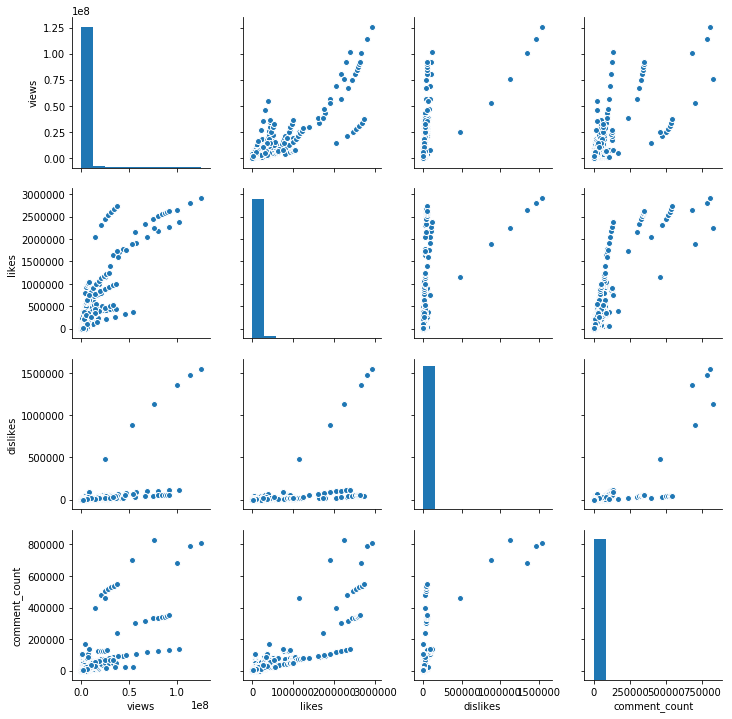

In [116]:
sns.pairplot(tidy[['views', 'likes', 'dislikes', 'comment_count']])

As you can see from the plot there are few videos that have a huge amount of comments and likes/dislikes, let's remove those outliers and replot

Remove outliers that are more than 3 std from the mean

In [117]:
outliers = tidy[(np.abs(scipy.stats.zscore(tidy[['comment_count', 'views', 'likes', 'dislikes']])) > 3).all(axis=1)]
tidy = tidy[(np.abs(scipy.stats.zscore(tidy[['comment_count', 'views', 'likes', 'dislikes']])) < 3).all(axis=1)] 

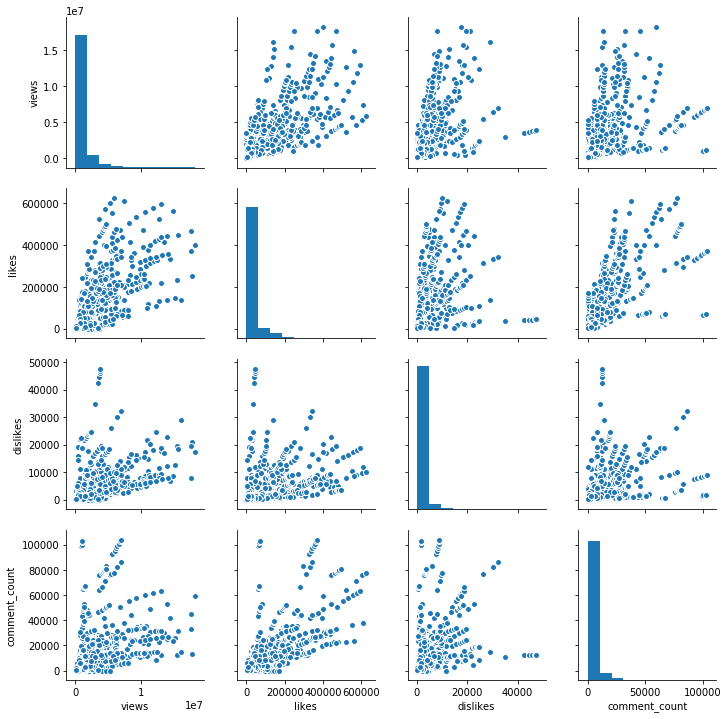

In [118]:
sns.pairplot(tidy[['views', 'likes', 'dislikes', 'comment_count']])

Now the data looks "better" without the outliers. Let's save the preprocessed data to disk

In [119]:
tidy.to_csv('tidy_usvideos.csv')

### Let's analyze the video categories

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

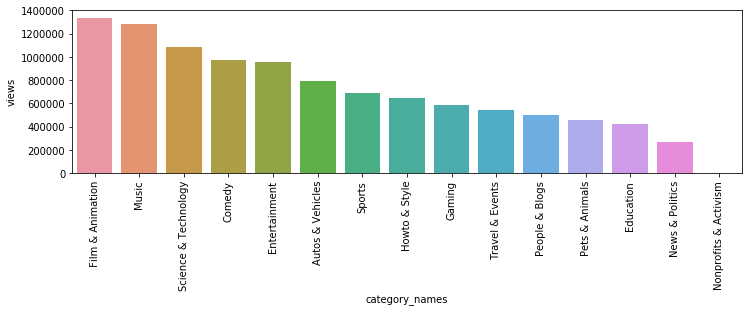

In [120]:
byviews = tidy.groupby('category_names').mean().reset_index().sort_values('views', ascending=False)
plt.figure(figsize=(12, 3))
sns.barplot(data=byviews, x='category_names', y='views', ci=None)
plt.xticks(rotation=90)

Seems like film & animation, music, and science and technology get the most views, while politics and news get the least. We can get the same plots for likes and dislikes for each category.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

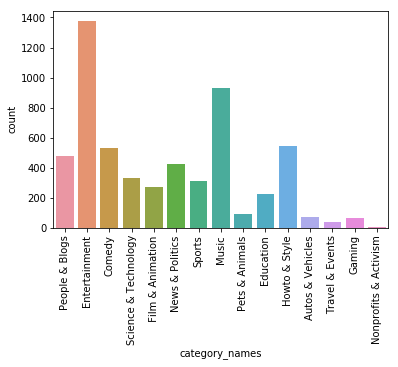

In [121]:
sns.countplot(x='category_names', data=tidy)
plt.xticks(rotation=90)

Look at the video counts, entertainment seems to have the most trending videos in the dataset

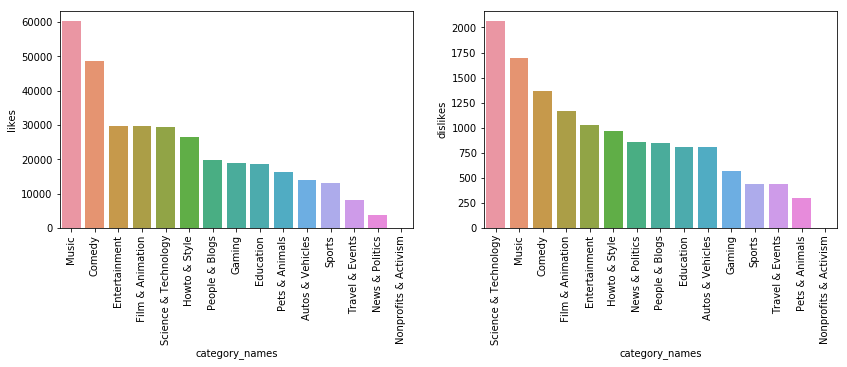

In [122]:
figs, ax = plt.subplots(1, 2)
fig.tight_layout()
plt.subplots_adjust(left=-0.9)


bylikes = tidy.groupby('category_names').mean().reset_index().sort_values('likes', ascending=False)
sns.barplot(data=bylikes, x='category_names', y='likes', ci=None, ax=ax[0])
bydislikes = tidy.groupby('category_names').mean().reset_index().sort_values('dislikes', ascending=False)
sns.barplot(data=bydislikes, x='category_names', y='dislikes', ci=None, ax=ax[1])

for axes in figs.axes:
    plt.sca(axes)
    plt.xticks(rotation=90)

We see that likes and dislikes are on par with each other. Let's see which categories get the most comments from viewers. This could give us insight into what category of videos the viewers like to show expression (by leaving comments).

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

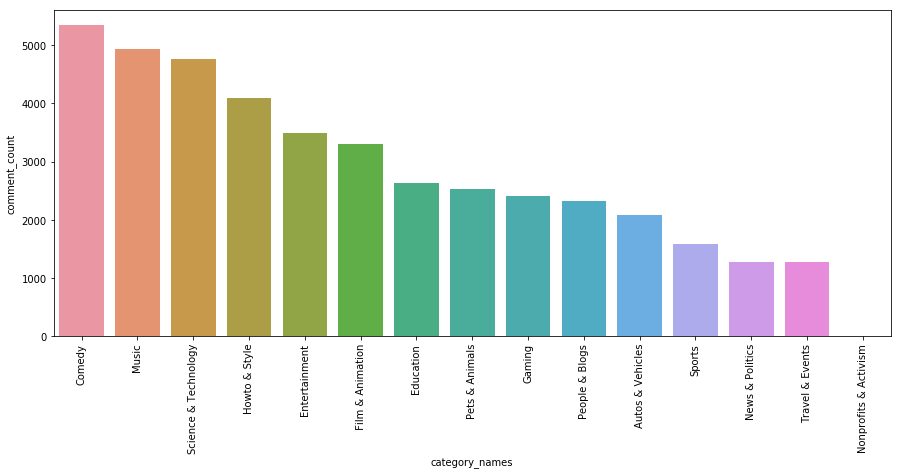

In [123]:
plt.figure(figsize=(15, 6))
bycomment = tidy.groupby('category_names').mean().reset_index().sort_values('comment_count', ascending=False)
sns.barplot(data=bycomment, x='category_names', y='comment_count', ci=None)
plt.xticks(rotation=90)

Let's get a sense of what time did the users like tp uoload their videos.

/home/anderson/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

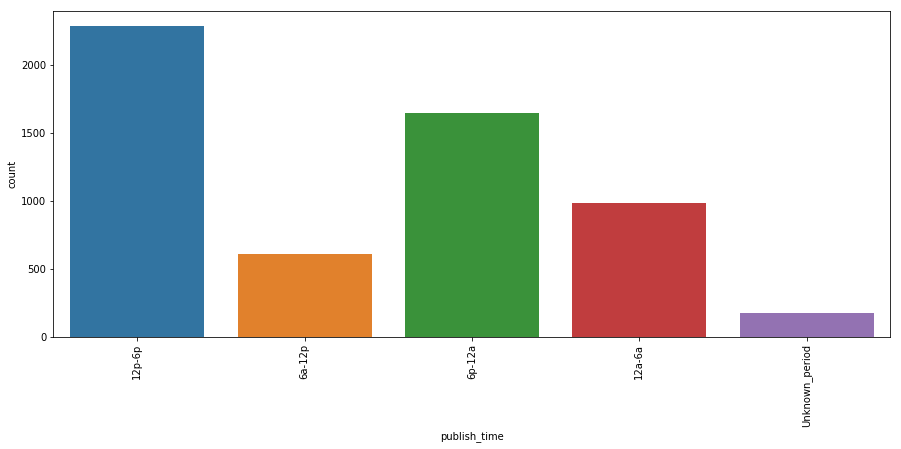

In [124]:
plt.figure(figsize=(15, 6))
sns.countplot(x='publish_time', data=tidy)
plt.legend(loc='upper right')
plt.xticks(rotation=90)

Seems like most of the videos seem to be uploaded in the afternoon. Now, we can see the count for each video category.

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

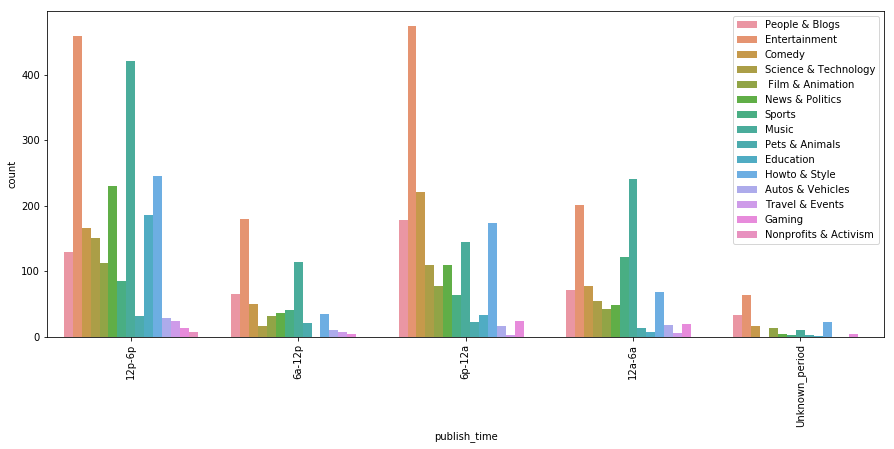

In [125]:
plt.figure(figsize=(15, 6))
sns.countplot(x='publish_time', data=tidy, hue='category_names')
plt.legend(loc='upper right')
plt.xticks(rotation=90)

Let's see how long it takes a video to trend, after the video has been published

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

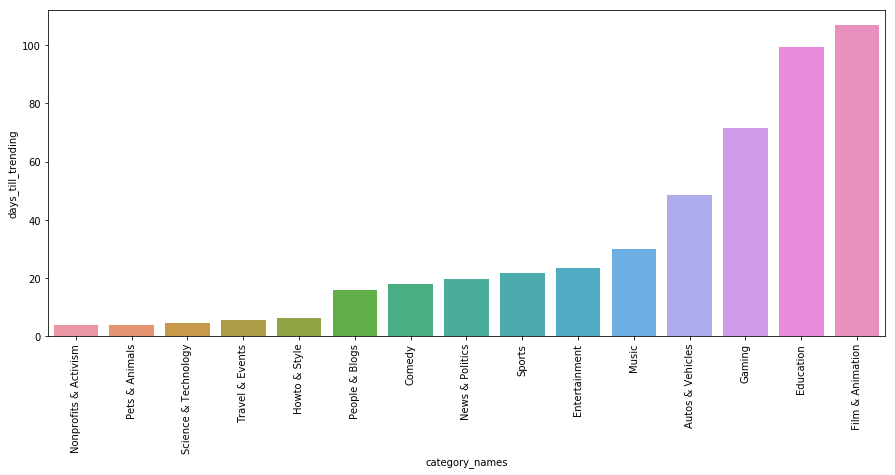

In [126]:
plt.figure(figsize=(15, 6))
bydays = tidy.groupby('category_names').mean().reset_index().sort_values(by='days_till_trending', ascending=True)
sns.barplot(x='category_names', y='days_till_trending', data=bydays, ci=False)
plt.xticks(rotation=90)

# Modelling

To model the data we are going to apply a one class Support Vector Machine hoping to discriminate the data from non trending videos.ing outside as  Think of it as creating a boundary around the data, and treating everything outside the boundary as outliers and negative examples. The dataset consist of positive (trending examples only). The only features we will use is the comment_count, views, likes, dislikes.

In [135]:
from sklearn import svm
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import scale

min_max_scaler = MinMaxScaler()

We will use a get_data function to get our values for the model and normalize each column using the MinMaxScaler

In [170]:
def transform_data(df):
    df = min_max_scaler.fit_transform(df)
    df = scale(df)
    return df

In [171]:
def get_data(df):
    vals = ['views', 'likes', 'comment_count', 'dislikes']
    df_x = df[vals]
    df_x = transform_data(df_x)
    df_y = np.ones(len(df_x))
    return df_x, df_y

In [172]:
def print_scores(name, predicted, true):
    print("{0} accuracy: ".format(name), metrics.accuracy_score(true, predicted))
    print()

We will separate the data into train and test. But we will also use a whole different dataset to do additional testing. We will be testing on the trending videos from france, germany, and canada dataset.

In [173]:
france_trending = pd.read_csv('data/FRvideos.csv')
germany_trending = pd.read_csv('data/DEvideos.csv')
canada_trending = pd.read_csv('data/CAvideos.csv')

canada_x, canada_y = get_data(canada_trending)
germany_x, germany_y = get_data(germany_trending)
france_x, france_y = get_data(france_trending)
train, y = get_data(tidy)
# p = int(len(all_data) * .70)
# train = all_data[:p]
# test = all_data[p:]
# train_y = np.ones(len(train))
# test_y = np.ones(len(test))

The parameters of the OneClass svm is nu, which controls how much error we allow the classifier to make, we'll set it to 0.05 for now

In [178]:
nu = 0.04

train the classifier using the Radial basic function kernel

In [179]:
model = svm.OneClassSVM(kernel='rbf', nu=nu)
model.fit(train)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma='auto', kernel='rbf',
      max_iter=-1, nu=0.04, random_state=None, shrinking=True, tol=0.001,
      verbose=False)

In [180]:
train_predict = model.predict(train)
france_predict = model.predict(france_x)
canada_predict = model.predict(canada_x)
germany_predict = model.predict(germany_x)

Below we can see the performance of the one class svm

In [181]:
print_scores("us trending", y, train_predict)
print_scores("france trending", france_y, france_predict)
print_scores("canada trending ", canada_y, canada_predict)
print_scores("germany trending", germany_y, germany_predict)

us trending accuracy:  0.959755030621

france trending accuracy:  0.987639788111

canada trending  accuracy:  0.977045320777

germany trending accuracy:  0.98587819947



By using a one class linear svm we are able to predict what videos will trend or not with decent accuracy. But after transforming the data by normalizing and standardizing we were able to achieve even better performance.